In [10]:
import sys

from imports.ExtractContactCases import ExtractContactCases
from imports.EventArrayAugmention import *
import math
import numpy as np

ex = ExtractContactCases(outdir='../data/small/contact_extraction5/', 
                         possible_angles=[math.radians(9)], 
                         N_examples=5,
                         theta=[0, 0, np.pi/6, np.pi/3, np.pi/2],
                         bag_file_name='/home/hussain/catkin_ws/small_example5_heavy_one_phi_4thetas.bag',
                         center=(180, 117),
                         circle_rad=85,
                         n_init_events=10000,
                         delta_t=0.075e9,
                         margin=-0.025e9,
                         event_array_augmentations=[
                             #RotateEvents(90),
                             #RotateEvents(180)
                             #JitterEvents(2)
                         ]
                        )

In [1]:
path 

NameError: name 'path' is not defined

In [11]:
ex.extract()

parsing bag:   0%|          | 0/73849 [00:00<?, ?msg/s]

extracting contact timestamps:   0%|          | 0/27660 [00:00<?, ?it/s]

extracting event arrays:   0%|          | 0/120 [00:00<?, ?it/s]

saving
1
2
1
1


In [ ]:
ex.params

In [4]:
samples = ex.load()

In [5]:
from models.modules import MaxPooling, MaxPoolingX
import torch
import torch_geometric

from torch.nn import Linear
from torch.nn.functional import elu
from torch_geometric.nn.conv import SplineConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import Cartesian
from torch_geometric.data import Data, Batch
from torch_geometric.nn.pool import radius_graph, knn_graph

from models.modules import TransitionDown
from torch_geometric import seed_everything

seed_everything(0)

class GraphRes(torch.nn.Module):

    def __init__(self):
        super(GraphRes, self).__init__()
        dim = 3

        bias = False
        root_weight = False
        pooling_size=(16/346, 12/260)

        # Set dataset specific hyper-parameters.
        kernel_size = 2
        n = [1, 8, 16, 16, 16, 32, 32, 32, 32]
        pooling_outputs = 16
        #kernel_size = 8
        #n = [1, 16, 32, 32, 32, 128, 128, 128]
        #pooling_outputs = 128

        self.conv1 = SplineConv(n[0], n[1], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm1 = BatchNorm(in_channels=n[1])
        self.td1 = TransitionDown(8, 8, ratio=0.25)
        
        self.conv2 = SplineConv(n[1], n[2], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm2 = BatchNorm(in_channels=n[2])

        self.pool7 = MaxPoolingX(0.25, size=16)
        self.fc = Linear(pooling_outputs * 16, out_features=2, bias=bias)

    def forward(self, data: torch_geometric.data.Batch) -> torch.Tensor:
        data.x = elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm1(data.x)
        x, pos, batch = self.td1(data.x, data.pos, data.batch)
        
        edge_index = radius_graph(pos, r=0.05, max_num_neighbors=16)
        data = Batch(x=x, pos=pos, batch=batch, edge_index=edge_index, y=data.y)
        data = Cartesian()(data)
        data.x = elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm2(data.x)

        x = self.pool7(data.x, pos=data.pos[:, :2], batch=data.batch)
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)

    
    
class GraphRes(torch.nn.Module):

    def __init__(self):
        super(GraphRes, self).__init__()
        dim = 3

        bias = False
        root_weight = False
        pooling_size=(16/346, 12/260)

        # Set dataset specific hyper-parameters.
        kernel_size = 2
        n = [1, 8, 16, 16, 16, 32, 32, 32, 32]
        pooling_outputs = 32
        #kernel_size = 8
        #n = [1, 16, 32, 32, 32, 128, 128, 128]
        #pooling_outputs = 128

        self.conv1 = SplineConv(n[0], n[1], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm1 = BatchNorm(in_channels=n[1])
        self.conv2 = SplineConv(n[1], n[2], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm2 = BatchNorm(in_channels=n[2])
        self.td2 = TransitionDown(n[2], n[2], 0.5)
        
        self.conv3 = SplineConv(n[2], n[3], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm3 = BatchNorm(in_channels=n[3])
        self.conv4 = SplineConv(n[3], n[4], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm4 = BatchNorm(in_channels=n[4])

        self.conv5 = SplineConv(n[4], n[5], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm5 = BatchNorm(in_channels=n[5])
        self.pool5 = MaxPooling(pooling_size, transform=Cartesian(norm=True, cat=False))

        self.conv6 = SplineConv(n[5], n[6], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm6 = BatchNorm(in_channels=n[6])
        self.conv7 = SplineConv(n[6], n[7], dim=dim, kernel_size=kernel_size, bias=bias, root_weight=root_weight)
        self.norm7 = BatchNorm(in_channels=n[7])

        self.pool7 = MaxPoolingX(0.25, size=16)
        self.fc = Linear(pooling_outputs * 16, out_features=2, bias=bias)

    def forward(self, data: torch_geometric.data.Batch) -> torch.Tensor:
        data.x = elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm1(data.x)
        data.x = elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm2(data.x)
        
        x, pos, batch = self.td2(data.x, data.pos, data.batch)
        edge_index = radius_graph(pos, r=0.05, max_num_neighbors=16)
        data = Batch(x=x, pos=pos, batch=batch, edge_index=edge_index, y=data.y)
        data = Cartesian()(data)

        x_sc = data.x.clone()
        data.x = elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm3(data.x)
        data.x = elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm4(data.x)
        data.x = data.x + x_sc

        data.x = elu(self.conv5(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm5(data.x)
        data = self.pool5(data.x, pos=data.pos, batch=data.batch, edge_index=data.edge_index, return_data_obj=True)

        x_sc = data.x.clone()
        data.x = elu(self.conv6(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm6(data.x)
        data.x = elu(self.conv7(data.x, data.edge_index, data.edge_attr))
        data.x = self.norm7(data.x)
        data.x = data.x + x_sc

        x = self.pool7(data.x, pos=data.pos[:, :2], batch=data.batch)
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)

In [6]:
from imports.TrainModel import TrainModel

#from models.modules import GraphRes

!rm -rf ../data/small/contact_extraction5/{test,train,val}/processed/*.pt
tm = TrainModel('../data/small/contact_extraction5/', GraphRes().cuda(), lr=0.01, features='pol', batch=4, n_epochs=300)

{'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag', 'train_prop': 0.75, 'delta_t': 75000000.0, 'margin': -25000000.0, 'min_n_events': 750, 'n_init_events': 10000, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 5, 'possible_angles': [0.15707963267948966], 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966], 'augmentations': ['JitterEvents(max_delta_x=2)']}


Processing...


{'N_examples': 5,
 'augmentations': ['JitterEvents(max_delta_x=2)'],
 'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag',
 'case_span': 2660000000.0,
 'center': [180, 117],
 'circle_rad': 85,
 'delta_t': 75000000.0,
 'margin': -25000000.0,
 'min_n_events': 750,
 'n_init_events': 10000,
 'node_features': 'pol',
 'possible_angles': [0.15707963267948966],
 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966],
 'train_prop': 0.75}
{'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag', 'train_prop': 0.75, 'delta_t': 75000000.0, 'margin': -25000000.0, 'min_n_events': 750, 'n_init_events': 10000, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 5, 'possible_angles': [0.15707963267948966], 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966], 'augmentations': ['JitterEvents(max_delta_x=2)'], 'node_features': 'pol'}


Done!
Processing...


{'N_examples': 5,
 'augmentations': ['JitterEvents(max_delta_x=2)'],
 'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag',
 'case_span': 2660000000.0,
 'center': [180, 117],
 'circle_rad': 85,
 'delta_t': 75000000.0,
 'margin': -25000000.0,
 'min_n_events': 750,
 'n_init_events': 10000,
 'node_features': 'pol',
 'possible_angles': [0.15707963267948966],
 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966],
 'train_prop': 0.75}
{'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag', 'train_prop': 0.75, 'delta_t': 75000000.0, 'margin': -25000000.0, 'min_n_events': 750, 'n_init_events': 10000, 'center': [180, 117], 'circle_rad': 85, 'case_span': 2660000000.0, 'N_examples': 5, 'possible_angles': [0.15707963267948966], 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966], 'augmentations': ['JitterEvents(max_delta_x=2)'], 'node_features': 'pol'}


Done!
Processing...


{'N_examples': 5,
 'augmentations': ['JitterEvents(max_delta_x=2)'],
 'bag': '/home/hussain/catkin_ws/small_example4_heavy_one_phi_4thetas.bag',
 'case_span': 2660000000.0,
 'center': [180, 117],
 'circle_rad': 85,
 'delta_t': 75000000.0,
 'margin': -25000000.0,
 'min_n_events': 750,
 'n_init_events': 10000,
 'node_features': 'pol',
 'possible_angles': [0.15707963267948966],
 'theta': [0, 0, 0.5235987755982988, 1.0471975511965976, 1.5707963267948966],
 'train_prop': 0.75}


Done!


In [7]:
tm.train()

training:   0%|          | 0/300 [00:00<?, ?epoch/s]

  0%|          | 0/23 [00:00<?, ?batch/s]

/home/hussain/me/projects/tactile/src/imports/TrainModel.py:90: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


  0%|          | 0/23 [00:00<?, ?batch/s]

logging


In [3]:
import numpy as np
c= np.array([tm.train_data[i].y.detach().numpy()[0] for i in range(len(tm.train_data))])

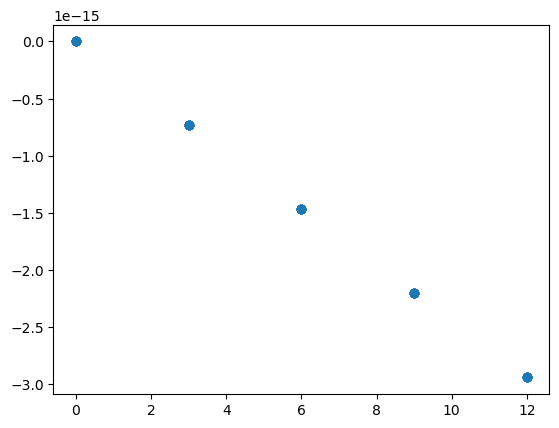

In [5]:
import matplotlib.pyplot as plt
plt.scatter(*np.degrees(c.T))

In [7]:
tm.val_data.root

PosixPath('../data/small/contact_extraction5/val')

In [13]:
tm.val_data[0]

Data(x=[4915, 1], edge_index=[2, 78132], y=[1, 2], pos=[4915, 3], edge_attr=[78132, 3])

In [25]:
import json
c=[]
with open('../data/small/contact_extraction5/train/raw/contact_cases.json') as f:
    val = json.load(f)
    for i, (s_idx, sample) in enumerate(val.items()):
        c.append(sample['case'])
       # print(tm.train_data[i].x.shape, len(sample['events']), sample['case'])

In [41]:
possible_angle = [math.radians(9)]#[math.radians(3), math.radians(6), math.radians(9), math.radians(12)]
N_examples = 5
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = [np.nan, 0, math.pi/6, math.pi/3, math.pi/2][i]#math.pi/2 #i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)

cases_dict = {i+1: list_of_rotations[i][:2] for i in range(len(list_of_rotations))}
cases_dict[0] = [0, 0]
cases_dict

5
[[0, 0, 0], [0.15707963267948966, 0.0, 0], [0.13603495231756635, 0.07853981633974481, 0], [0.07853981633974484, 0.13603495231756632, 0], [9.618353468608949e-18, 0.15707963267948966, 0]]


{1: [0, 0],
 2: [0.15707963267948966, 0.0],
 3: [0.13603495231756635, 0.07853981633974481],
 4: [0.07853981633974484, 0.13603495231756632],
 5: [9.618353468608949e-18, 0.15707963267948966],
 0: [0, 0]}

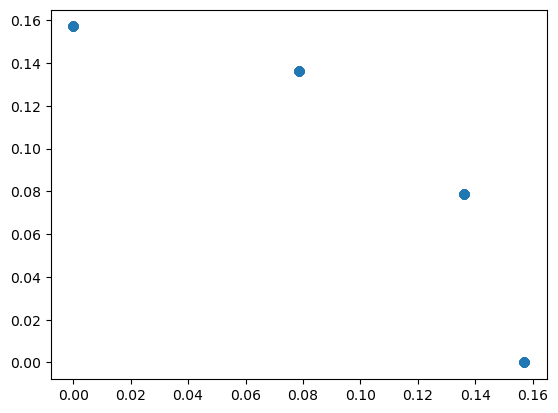

In [42]:
plt.scatter(*np.array([cases_dict[i] for i in c]).T)

In [39]:
with open('../data/small/contact_extraction5/samples.json') as f:
    val = json.load(f)
    for i, (s_idx, sample) in enumerate(val.items()):
        c.append(sample['case'])

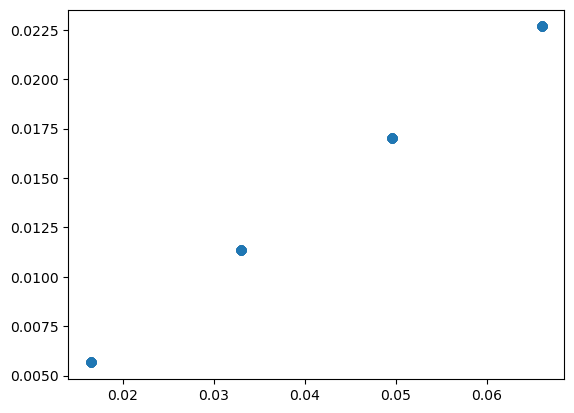

In [40]:
plt.scatter(*np.array([cases_dict[i] for i in c]).T)

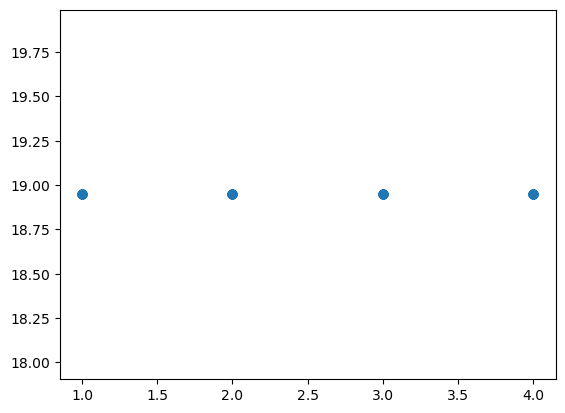

In [36]:
import numpy as np
def rotvec2spherical(rot_vec):
    rx, ry = rot_vec.T.astype(float)
    phi = np.sqrt(rx**2 + ry**2)
    theta = np.arctan2(ry, rx)
    
    return phi, theta

plt.scatter(*np.degrees(rotvec2spherical(np.array([cases_dict[i] for i in c]))))

In [10]:
cases_val = [i.y for i in tm.train_loader]
cases_val

[tensor([[ 1.0472e-01, -2.5649e-17],
         [ 1.5708e-01, -3.8473e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 1.0472e-01, -2.5649e-17]]),
 tensor([[ 2.0944e-01, -5.1298e-17],
         [ 1.5708e-01, -3.8473e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 1.5708e-01, -3.8473e-17]]),
 tensor([[ 5.2360e-02, -1.2824e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 5.2360e-02, -1.2824e-17],
         [ 1.0472e-01, -2.5649e-17]]),
 tensor([[ 2.0944e-01, -5.1298e-17],
         [ 2.0944e-01, -5.1298e-17],
         [ 2.0944e-01, -5.1298e-17],
         [ 1.0472e-01, -2.5649e-17]]),
 tensor([[ 2.0944e-01, -5.1298e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 1.0472e-01, -2.5649e-17]]),
 tensor([[ 5.2360e-02, -1.2824e-17],
         [ 5.2360e-02, -1.2824e-17],
         [ 1.0472e-01, -2.5649e-17],
         [ 1.5708e-01, -3.8473e-17]]),
 tensor([[ 2.0944e-01, -5.1298e-17],
         [ 2.0944e-01, -5.1298e-17],
         [ 5.2360e-02, -1.